Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAttention: The specified module could not be found.
Could not load the custom kernel for multi-scale deformable attention: DLL load failed while importing MultiScaleDeformableAt


0: 1024x1024 1 0, 1 1, 1 2, 4842.4ms
Speed: 12.1ms preprocess, 4842.4ms inference, 4.3ms postprocess per image at shape (1, 3, 1024, 1024)


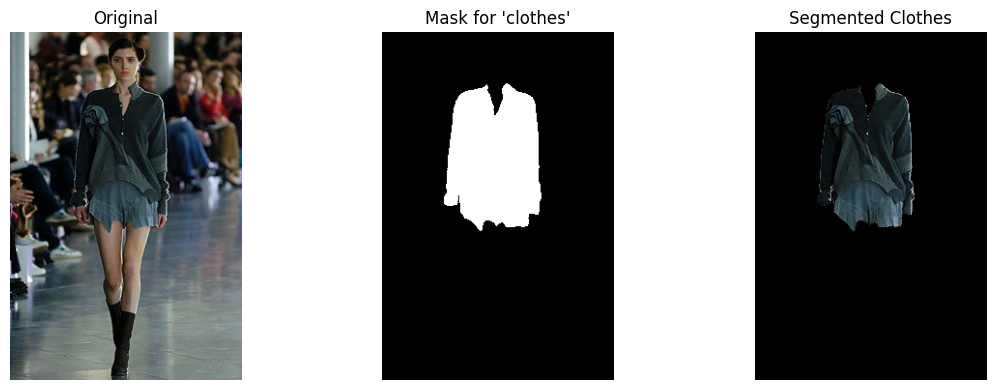

In [29]:
import cv2
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from ultralytics import SAM
import matplotlib.pyplot as plt


# 1️ Load Grounding DINO from Hugging Face
model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id, use_fast=True)
dino = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
dino.eval()

# 2️ Load SAM 2
sam = SAM("sam2_b.pt").to(device).eval()

# 3️ Load your image
img_path = "vogue_runway_000/0000001_Preen by Thornton Bregazzi - Fall 2004 Ready-to-Wear [Collection].jpg"
img_cv = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# 4️ Run Grounding DINO with prompt "clothes."
text_prompt = ["clothes."]  # lowercase + trailing dot is important :contentReference[oaicite:5]{index=5}
inputs = processor(images=img_rgb, text=text_prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = dino(**inputs)

# 5️ Post-process detections
target_sizes = torch.tensor([img_rgb.shape[:2]])
results = processor.post_process_grounded_object_detection(
    outputs, inputs.input_ids, box_threshold=0.3, text_threshold=0.25, target_sizes=target_sizes
)

boxes = results[0]['boxes']
scores = results[0]['scores']
labels = results[0]['labels']

if boxes is None or (hasattr(boxes, 'numel') and boxes.numel() == 0) or (isinstance(boxes, (list, tuple)) and len(boxes) == 0):
    raise RuntimeError("No clothing boxes detected")

# 6️ Convert boxes to [x0,y0,x1,y1] for SAM
bboxes = [box.tolist() for box in boxes]

# 7️Pass to SAM 2 to get masks
sam_result = sam.predict(img_rgb, bboxes=bboxes, device=device)
mask = sam_result[0].masks.data[0].cpu().numpy().astype(bool)

# 8️Apply mask (keep clothes, remove everything else)
clothes_only = img_rgb.copy()
clothes_only[~mask] = 0

cv2.imwrite("cleaned_clothes.png", cv2.cvtColor(clothes_only, cv2.COLOR_RGB2BGR))
image = Image.fromarray(clothes_only)
image.show()

# 9️Visualize results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(mask, cmap="gray"); plt.title("Mask for 'clothes'"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(clothes_only); plt.title("Segmented Clothes"); plt.axis("off")
plt.tight_layout()
plt.show()


In [30]:
import torch
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPVisionModel
import torch.nn as nn

# === 1. Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. Load Class Labels ===
with open("labels.txt", "r", encoding="utf-8") as f:
    class_names = [line.strip() for line in f if line.strip()]
num_classes = len(class_names)

# === 3. Model Architecture (Same as training) ===
class CLIPViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.clip_vit = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.clip_vit.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.clip_vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output
        logits = self.classifier(self.dropout(pooled_output))
        return logits

# === 4. Load Trained Model ===
model = CLIPViTClassifier(num_classes)
model.load_state_dict(torch.load("clip-vit-fabric-hf/pytorch_model.bin", map_location=device))  # adjust path if needed
model.to(device).eval()

# === 5. Image Preprocessing ===
image_path = "cleaned_clothes.png"
image = Image.open(image_path).convert("RGB")

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
inputs = processor(images=image, return_tensors="pt").to(device)  # includes pixel_values

# === 6. Predict ===
with torch.no_grad():
    logits = model(inputs["pixel_values"])
    probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()

predicted_idx = int(np.argmax(probs))
predicted_label = class_names[predicted_idx]
confidence = float(probs[predicted_idx])

# === 7. Output ===
print("\n✅ Single Image Prediction")
for i, (label, prob) in enumerate(zip(class_names, probs)):
    print(f"{i+1:02d}. {label:30s} | Confidence: {prob:.4f}")
print(f"\n🎯 Predicted: {predicted_label} (Confidence: {confidence:.2f})")



✅ Single Image Prediction
01. abstract_geometric_fabric      | Confidence: 0.0003
02. argyle_fabric                  | Confidence: 0.0017
03. checked_fabric                 | Confidence: 0.0017
04. chevron_fabric                 | Confidence: 0.0005
05. diagonal_grid_fabric_pattern   | Confidence: 0.0016
06. floral_fabric                  | Confidence: 0.0002
07. fringe_fabric                  | Confidence: 0.0033
08. glitch_print_fabric            | Confidence: 0.0022
09. glitter_fabric                 | Confidence: 0.0052
10. gradient_fabric                | Confidence: 0.0625
11. graffiti_print_fabric          | Confidence: 0.0015
12. holographic_fabric             | Confidence: 0.0024
13. houndstooth_fabric             | Confidence: 0.0006
14. illustrative_graphic_print     | Confidence: 0.0008
15. lace_fabric                    | Confidence: 0.0011
16. leaf_print_fabric              | Confidence: 0.0008
17. leopard_print_fabric           | Confidence: 0.0003
18. marble_pattern_fa

In [21]:
from collections import Counter
print("Train label distribution:", Counter(y_train))


Train label distribution: Counter({25: 281, 21: 257, 2: 242, 22: 221, 0: 218, 16: 198, 12: 197, 4: 195, 19: 192, 17: 185, 26: 183, 3: 177, 11: 173, 15: 172, 8: 168, 5: 156, 23: 152, 1: 150, 10: 148, 20: 147, 28: 145, 7: 141, 6: 137, 18: 133, 24: 129, 9: 112, 14: 102, 13: 94, 27: 63})
